In [130]:
import pandas as pd
import pandas_profiling
import os
import pickle
import gc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")

In [131]:
# まずは少ない特徴量から検討していく
X_train = train[['DiabetesPedigreeFunction','BMI','Glucose']]
id_train = train[['index']]
y_train = train[['Outcome']]

In [73]:
len(X_train)
len(y_train)

3000

ベースライン評価のため一部データを分ける。

残りのデータでvalidationしてその条件・目的変数・validation方法・評価指標を仮定し評価する。

上記3項目を明確にすることをベースラインの決定とする。

validationした後にベースライン評価のためのデータで評価しベースラインを検証する。

validation時とベースライン検証時の結果の傾向に大きな差が無ければベースラインの3項目は問題ないと判断する。

ベースラインが決定すると、その後EDAやモデル改善後はvalidationのみを行い進めていく。
（変更点や結果を記録）

## validation方法（ベースライン作成へ）

In [138]:
params = {
    'boosting_type' :'gbdt',
    'objective' : 'binary',
    'metrics' : 'auc',
    'learning_rate' : 0.1,
    'num_leaves' : 16,
    'random_state' : random_state,
    'importance_type' : 'gain',
}
random_state = 123

In [149]:
# cvでの評価用
def train_cv(input_x,
             input_y,
             input_id,
             params,
             random_state=123,
             n_splits=5
            ):
    
    metrics = []
    imp = pd.DataFrame()
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).
              split(input_x, input_y))
    
    
    for nfold in np.arange(n_splits):
        print('-'*20, nfold, '-'*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['Outcome'].mean(), y_tr['Outcome'].mean(), y_va['Outcome'].mean(),))

        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr),(x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=100,
                 )

        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        metric_tr = accuracy_score(y_tr, y_tr_pred)
        metric_va = accuracy_score(y_va, y_va_pred)
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])

        _imp = pd.DataFrame({'col':input_x.columns, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print('-'*20, 'result', '-'*20)
    metrics = np.array(metrics)
    print(metrics)

    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))

    imp = imp.groupby('col')['imp'].agg(['mean', 'std'])
    imp.columns = ['imp', 'imp_std']
    imp = imp.reset_index(drop=False)
    imp.sort_values('imp', ascending=False, ignore_index=True)
    print('-'*20, 'imp', '-'*20)
    print(imp)

    print('Done')
    
    return imp, metrics

In [150]:
imp, metrics = train_cv(X_train, y_train, id_train, params, random_state=random_state, n_splits=4)

-------------------- 0 --------------------
(2250, 3) (2250, 1)
(750, 3) (750, 1)
y_train:0.239, y_tr:0.239, y_va0.240
[100]	training's auc: 0.920533	valid_1's auc: 0.715975
[accuracy] tr: 0.86, va: 0.773333
-------------------- 1 --------------------
(2250, 3) (2250, 1)
(750, 3) (750, 1)
y_train:0.239, y_tr:0.239, y_va0.239
[100]	training's auc: 0.920464	valid_1's auc: 0.714629
[accuracy] tr: 0.85, va: 0.773333
-------------------- 2 --------------------
(2250, 3) (2250, 1)
(750, 3) (750, 1)
y_train:0.239, y_tr:0.239, y_va0.239
[100]	training's auc: 0.916344	valid_1's auc: 0.72839
[accuracy] tr: 0.85, va: 0.762667
-------------------- 3 --------------------
(2250, 3) (2250, 1)
(750, 3) (750, 1)
y_train:0.239, y_tr:0.239, y_va0.239
[100]	training's auc: 0.923504	valid_1's auc: 0.716586
[accuracy] tr: 0.86, va: 0.770667
-------------------- result --------------------
[[0.         0.85955556 0.77333333]
 [1.         0.85377778 0.77333333]
 [2.         0.84844444 0.76266667]
 [3.        

## 推論

In [127]:
# 推論用に全てのデータで学習
x_tr, x_va, y_tr, y_va = train_test_split(X_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train,
                                          random_state=random_state)

model = lgb.LGBMClassifier(**params)
model.fit(x_tr,
          y_tr,
          eval_set=[(x_tr,y_tr),(x_va,y_va)],
          early_stopping_rounds=100,
          verbose=10,
         )

[10]	training's auc: 0.759745	valid_1's auc: 0.649332
[20]	training's auc: 0.783829	valid_1's auc: 0.660311
[30]	training's auc: 0.801325	valid_1's auc: 0.656249
[40]	training's auc: 0.813381	valid_1's auc: 0.656325
[50]	training's auc: 0.824786	valid_1's auc: 0.657289
[60]	training's auc: 0.834786	valid_1's auc: 0.657213
[70]	training's auc: 0.842316	valid_1's auc: 0.654833
[80]	training's auc: 0.848086	valid_1's auc: 0.652063
[90]	training's auc: 0.853038	valid_1's auc: 0.652614
[100]	training's auc: 0.858739	valid_1's auc: 0.651895


LGBMClassifier(importance_type='gain', metrics='auc', num_leaves=16,
               objective='binary', random_state=123)

In [128]:
X_test = test[['DiabetesPedigreeFunction','BMI']]
id_test = test[['index']]
y_test_pred = model.predict(X_test).astype('int')
df_sub = pd.DataFrame({'index':id_test['index'], 'Outcome':y_test_pred})
display(df_sub.head(5))
df_sub.to_csv('submission.csv', index=None, header=False,)

,index,Outcome
0,398,1
1,3833,0
2,4836,0
3,4572,0
4,636,1


## ベースライン検証

### 初めに検討し問題なければ、その後はスキップ可能

ベースライン（評価指標や検証法、特徴量選択）の評価を行う

① 検証データの評価値とベースライン評価値のギャップが小さいか確認

② 後分類の傾向が似ているか確認

③ 予測値の分布が似ているか確認

上記3点が問題なければ、ベースラインを決定し、EDAやモデル改善を行う。

In [97]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (2400, 2) (2400, 1)
ベースライン検証データ:  (600, 2) (600, 1)
検証データ(train):  (1920, 2) (1920, 1)
検証データ(test):  (480, 2) (480, 1)


In [98]:
#validation結果
model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1),(x_va1,y_va1)],
          early_stopping_rounds=100,
          verbose=10,
         )

[10]	training's auc: 0.774768	valid_1's auc: 0.645634
[20]	training's auc: 0.798016	valid_1's auc: 0.651638
[30]	training's auc: 0.813006	valid_1's auc: 0.646337
[40]	training's auc: 0.830381	valid_1's auc: 0.646123
[50]	training's auc: 0.84587	valid_1's auc: 0.646051
[60]	training's auc: 0.856523	valid_1's auc: 0.641989
[70]	training's auc: 0.864736	valid_1's auc: 0.638606
[80]	training's auc: 0.873103	valid_1's auc: 0.632519
[90]	training's auc: 0.879872	valid_1's auc: 0.627028
[100]	training's auc: 0.884502	valid_1's auc: 0.629005


LGBMClassifier(importance_type='gain', metrics='auc', num_leaves=16,
               objective='binary', random_state=123)

In [99]:
#評価指標の差
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)
print('[検証データ] acc: {:.4f}'.format(accuracy_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] acc: {:.4f}'.format(accuracy_score(y_va2, y_va2_pred)))

[検証データ] acc: 0.7688
[ベースライン検証データ] acc: 0.7583


In [104]:
#後分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[344  21]
 [ 90  25]]
[[0.71666667 0.04375   ]
 [0.1875     0.05208333]]
ベースライン検証データ
[[431  26]
 [119  24]]
[[0.71833333 0.04333333]
 [0.19833333 0.04      ]]


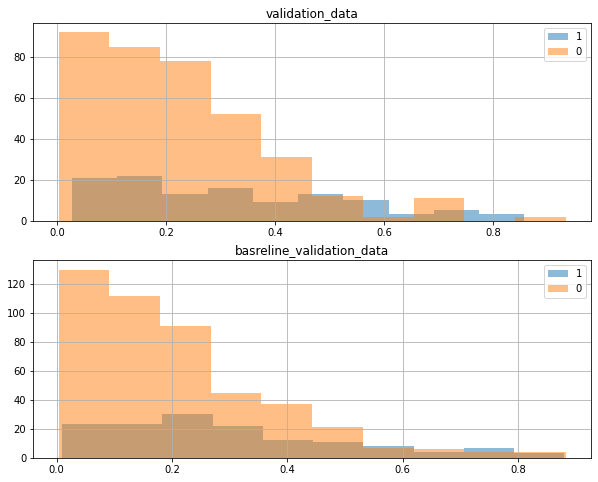

In [117]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()